In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             mean_squared_error, r2_score, roc_curve)

from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier 
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans

# Handling Imbalance and pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Explainability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [60]:
# Load the dataset
df = pd.read_excel('loan_dataset.xlsx', sheet_name='Sheet1')

def check_data_quality(df):
    print("--- 🔍 DATA QUALITY AUDIT ---")
    print(f"1. Missing Values: {df.isnull().sum().sum()} {'⚠️' if df.isnull().sum().sum() > 0 else '✅'}")
    print(f"2. Duplicates: {df.duplicated().sum()} {'⚠️' if df.duplicated().sum() > 0 else '✅'}")
    
    # Logic Check
    monthly_inc = df['AnnualIncome'] / 12
    impossible_debt = df[df['MonthlyDebtPayments'] > monthly_inc].shape[0]
    print(f"3. High Risk Flags (Debt > Income): {impossible_debt} records")
    
    print("-------------------------------")

check_data_quality(df)

--- 🔍 DATA QUALITY AUDIT ---
1. Missing Values: 0 ✅
2. Duplicates: 0 ✅
3. High Risk Flags (Debt > Income): 18 records
-------------------------------


In [61]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])

# Temporal Features
df['App_Year'] = df['ApplicationDate'].dt.year
df['App_Month'] = df['ApplicationDate'].dt.month
df['App_DayOfWeek'] = df['ApplicationDate'].dt.dayofweek
df['App_Is_Weekend'] = df['App_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

print("✅ Date Features Created")

✅ Date Features Created


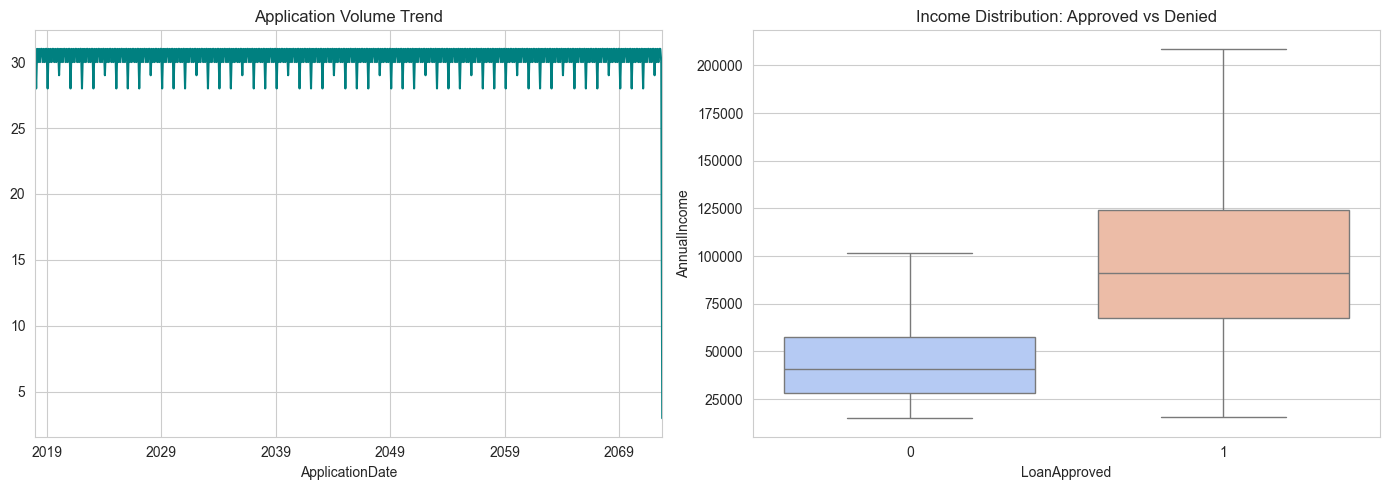

In [62]:
plt.figure(figsize=(14, 5))

# Plot 1: Volume over time
plt.subplot(1, 2, 1)
df.set_index('ApplicationDate').resample('M').size().plot(color='teal')
plt.title("Application Volume Trend")

# Plot 2: Income by Approval
plt.subplot(1, 2, 2)
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df, showfliers=False, palette='coolwarm')
plt.title("Income Distribution: Approved vs Denied")

plt.tight_layout()
plt.show()

In [63]:
# 1. Monthly Income
df['MonthlyIncome'] = df['AnnualIncome'] / 12

# 2. Debt-to-Income (DTI)
df['Calculated_DTI'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / (df['MonthlyIncome'] + 1)

# 3. Loan-to-Value (LTV)
df['LTV'] = df['LoanAmount'] / (df['TotalAssets'] + 1)

# 4. Liquidity Ratio
df['Liquidity_Ratio'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / (df['MonthlyLoanPayment'] + 1)

# 5. Disposable Income
df['Disposable_Income'] = df['MonthlyIncome'] - (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment'])

print("✅ Financial Ratios Calculated")

✅ Financial Ratios Calculated


In [64]:
print("--- 🕵️ ANOMALY DETECTION ---")
anomaly_features = ['AnnualIncome', 'TotalAssets', 'TotalLiabilities', 'LoanAmount']

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Is_Anomaly'] = iso_forest.fit_predict(df[anomaly_features])
df['Is_Anomaly'] = df['Is_Anomaly'].map({1: 0, -1: 1}) # 1 = Anomaly

print(f"Anomalies Detected: {df['Is_Anomaly'].sum()} records")

--- 🕵️ ANOMALY DETECTION ---
Anomalies Detected: 1000 records


In [65]:
print("--- 👥 CUSTOMER SEGMENTATION ---")
cluster_cols = ['AnnualIncome', 'RiskScore', 'TotalAssets']
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_cols])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)

print("✅ Segmentation Feature 'Customer_Segment' Created")

--- 👥 CUSTOMER SEGMENTATION ---
✅ Segmentation Feature 'Customer_Segment' Created


In [66]:
# Drop columns
X = df.drop(columns=['LoanApproved', 'RiskScore', 'ApplicationDate'])
y_class = df['LoanApproved']
y_reg = df['RiskScore']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Identify Column Types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['Customer_Segment', 'Is_Anomaly', 'App_Is_Weekend']) 
numerical_cols = [col for col in X.select_dtypes(include=['number']).columns if col not in categorical_cols]

# Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("✅ Preprocessing Pipeline Configured")

✅ Preprocessing Pipeline Configured


In [67]:
print("--- 🥊 MODEL COMPARISON (CatBoost vs SVM vs XGBoost) ---")

models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'SVM': SVC(probability=True, random_state=42, max_iter=1000), # Limited iter for speed
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []
print(f"{'Model':<15} | {'AUC Score':<10} | {'Status'}")
print("-" * 40)

for name, model in models.items():
    # Use ImbPipeline to fix SMOTE leakage
    temp_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Cross Validation (3-Fold for speed)
    cv_scores = cross_val_score(temp_pipeline, X_train, y_train, cv=3, scoring='roc_auc')
    mean_score = cv_scores.mean()
    
    results.append({'Model': name, 'AUC': mean_score})
    print(f"{name:<15} | {mean_score:.4f}     | ✅ Tested")

# Determine Winner
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
best_model_name = results_df.iloc[0]['Model']

print(f"\n🏆 WINNER: {best_model_name}")
print(results_df)

--- 🥊 MODEL COMPARISON (CatBoost vs SVM vs XGBoost) ---
Model           | AUC Score  | Status
----------------------------------------


CatBoost        | 0.9938     | ✅ Tested
SVM             | 0.8331     | ✅ Tested
XGBoost         | 0.9932     | ✅ Tested

🏆 WINNER: CatBoost
      Model       AUC
0  CatBoost  0.993808
2   XGBoost  0.993203
1       SVM  0.833073


In [68]:
print(f"--- 🚀 TUNING THE WINNER: {best_model_name} ---")

# 1. Define Model & Param Grid based on Winner
if best_model_name == 'CatBoost':
    clf = CatBoostClassifier(verbose=0, random_state=42)
    param_grid = {
        'classifier__iterations': [100, 300],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__depth': [4, 6]
    }
elif best_model_name == 'XGBoost':
    clf = XGBClassifier(eval_metric='logloss', random_state=42)
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    }
else: # SVM
    clf = SVC(probability=True, random_state=42)
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf']
    }

# 2. Setup Pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', clf)
])

# 3. Run Grid Search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

print("⏳ Running Optimization...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"✅ Best Params: {grid_search.best_params_}")
print(f"📈 Best CV Score: {grid_search.best_score_:.4f}")

--- 🚀 TUNING THE WINNER: CatBoost ---
⏳ Running Optimization...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best Params: {'classifier__depth': 4, 'classifier__iterations': 300, 'classifier__learning_rate': 0.1}
📈 Best CV Score: 0.9936


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3044
           1       0.92      0.94      0.93       956

    accuracy                           0.97      4000
   macro avg       0.95      0.96      0.95      4000
weighted avg       0.97      0.97      0.97      4000



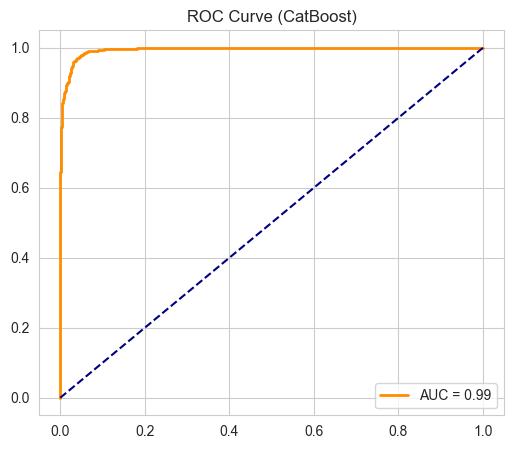

In [69]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f'ROC Curve ({best_model_name})')
plt.legend()
plt.show()

In [70]:
print("--- OBJECTIVE B: RISK SCORE PREDICTION ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"RMSE: {rmse:.2f} (Lower is better)")

--- OBJECTIVE B: RISK SCORE PREDICTION ---
RMSE: 3.63 (Lower is better)


--- EXPLAINABILITY ANALYSIS ---


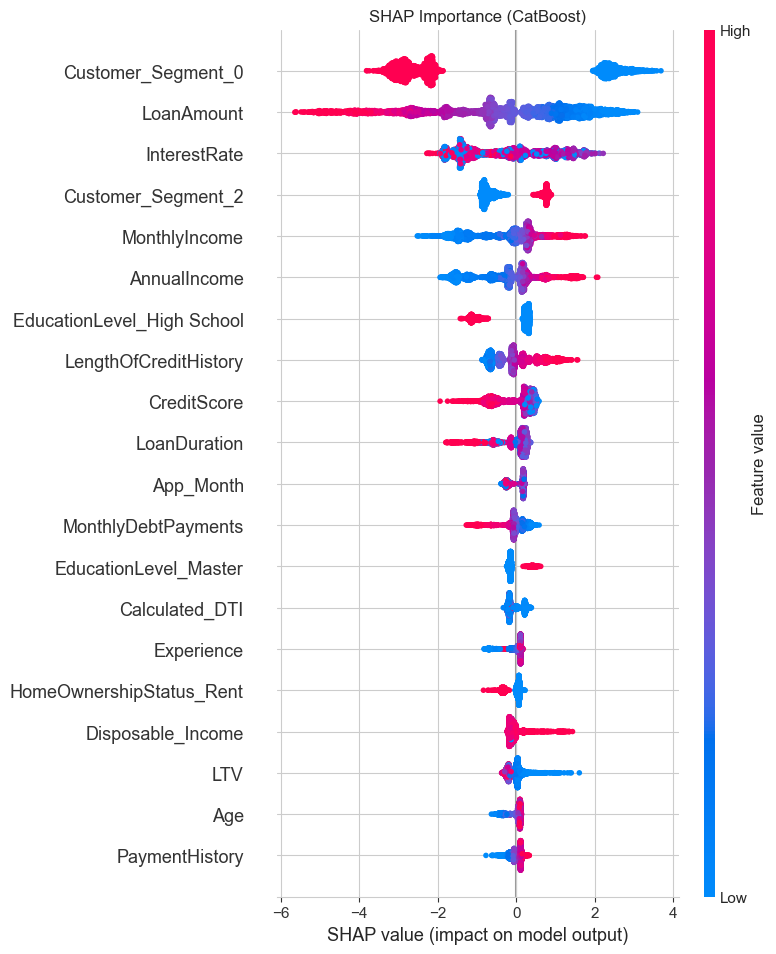

In [71]:
print("--- EXPLAINABILITY ANALYSIS ---")

# Transform data
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Get feature names
try:
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols)
    all_feats = numerical_cols + list(cat_names)
except:
    all_feats = [f"Feat_{i}" for i in range(X_test_transformed.shape[1])]

# Select Explainer based on Model Type
model_step = best_model.named_steps['classifier']
if 'SVC' in str(type(model_step)):
    print("⚠️ SVM detected. SHAP KernelExplainer is slow on large data. Skipping plot to prevent crash.")
    print("Note: Feature importance is less direct in SVM RBF kernels.")
else:
    # Works for XGBoost and CatBoost
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_test_transformed)
    
    plt.figure()
    shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feats, show=False)
    plt.title(f"SHAP Importance ({best_model_name})")
    plt.show()

In [73]:
joblib.dump(best_model, 'advanced_loan_model.pkl')
joblib.dump(reg_pipeline, 'risk_score_pipeline.pkl')

print(f"""
1. Champion Model: {best_model_name}
2. Performance (AUC): {roc_auc_score(y_test, y_prob):.4f}
3. Pipeline includes:
   - SMOTE (No Leakage)
   - {best_model_name} / SVM / XGBoost Comparison
   - Financial Feature Engineering
   - Customer Segmentation
""")


1. Champion Model: CatBoost
2. Performance (AUC): 0.9946
3. Pipeline includes:
   - SMOTE (No Leakage)
   - CatBoost / SVM / XGBoost Comparison
   - Financial Feature Engineering
   - Customer Segmentation

